In [1]:
import pandas as pd
import numpy as np
import pickle, gc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Соревнование  [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/) на сайте Kaggle.

В соревновании предоставлены 3 файла с данными: тренировочные, таргет значения для тренировочных данны и тестовые данные. 

**Цель соревнования** состоит в предсказании того, что клиент American Express не вернет остаток средств по своей кредитной карте. Если клиент не платил более 120 дней после последней выписки ему присваивается целевое значение - 1, в ином случае целевое значение равно 0. 

**На тестовых данных необходимо определить погасит клиент свою задолженость или нет.**


В датасете присутствуют столбцы разделенные на следующие группы: 
* D_*: переменные просроченной задолженности
* S_*: расходные переменные
* P_*: платежные переменные
* B_*: балансовые переменные
* R_*: переменные риска



# Импорт данных

In [2]:
train_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/train_data.ftr')
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


**Размер датасета**

In [ ]:
train_df.shape

(5531451, 191)

**Общая информация о датафрейме**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB


**Количество колонок по типу данных**

In [ ]:
import io
buffer = io.StringIO()

train_df.info(buf=buffer)
types_df = buffer.getvalue().split('\n')[3]

print(*types_df.replace('dtypes: ', '').split(', '), sep='\n')

category(11)
datetime64[ns](1)
float16(177)
int64(1)
object(1)


Количество признаков по столбцам
* category - 11
* datetime64[ns] - 1
* float16 - 177
* int64 - 1
* object -1

**Категориальные данные**

In [ ]:
train_df.describe(include=["category"])

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
count,5531451,5531451,623354.0,5314948.0,5529435.0,5529435.0,5354735.0,5354735.0,5354735.0,5354735.0,5414635.0
unique,6,5,2.0,7.0,3.0,7.0,2.0,2.0,7.0,2.0,3.0
top,CO,O,1.0,6.0,0.0,2.0,1.0,0.0,-1.0,0.0,1.0
freq,4119621,2913244,617066.0,2782455.0,4710663.0,1953232.0,3316478.0,5348109.0,1456084.0,4729723.0,4262414.0


In [ ]:
cat_fit = train_df.select_dtypes('category').columns.to_list()

print('Категориальные столбцы:', *cat_fit)
print('Столбец с датой:', 
      *train_df.select_dtypes('datetime64[ns]').columns.to_list())

Категориальные столбцы: D_63 D_64 D_66 D_68 B_30 B_38 D_114 D_116 D_117 D_120 D_126
Столбец с датой: S_2


**Уникальные значения в категориальных столбцах**

In [ ]:
for c_i in cat_fit:
    print(f'Уникальные значения для столбца {c_i}: {pd.unique(train_df[c_i]).to_list()}')

Уникальные значения для столбца D_63: ['CR', 'CO', 'CL', 'XZ', 'XM', 'XL']
Уникальные значения для столбца D_64: ['O', 'R', '', 'U', '-1']
Уникальные значения для столбца D_66: [nan, 1.0, 0.0]
Уникальные значения для столбца D_68: [6.0, 2.0, 3.0, nan, 5.0, 4.0, 0.0, 1.0]
Уникальные значения для столбца B_30: [0.0, 2.0, 1.0, nan]
Уникальные значения для столбца B_38: [2.0, 1.0, 3.0, 5.0, 6.0, 7.0, 4.0, nan]
Уникальные значения для столбца D_114: [1.0, 0.0, nan]
Уникальные значения для столбца D_116: [0.0, nan, 1.0]
Уникальные значения для столбца D_117: [4.0, -1.0, 6.0, 2.0, 1.0, nan, 3.0, 5.0]
Уникальные значения для столбца D_120: [0.0, 1.0, nan]
Уникальные значения для столбца D_126: [1.0, nan, 0.0, -1.0]


In [ ]:
print(f'Временной интервал датасета с {train_df["S_2"].min()} по {train_df["S_2"].max()}.')

Временной интервал датасета с 2017-03-01 00:00:00 по 2018-03-31 00:00:00.


## Пропущенные значения

**Относительное кол-во пропущенных значений**

In [ ]:
missing_values = train_df.isna().mean().sort_values(ascending=False)
missing_values.head(10)

D_87     0.999301
D_88     0.998915
D_108    0.994768
D_111    0.994335
D_110    0.994335
B_39     0.993920
D_73     0.989902
B_42     0.987078
D_136    0.964801
D_138    0.964801
dtype: float64

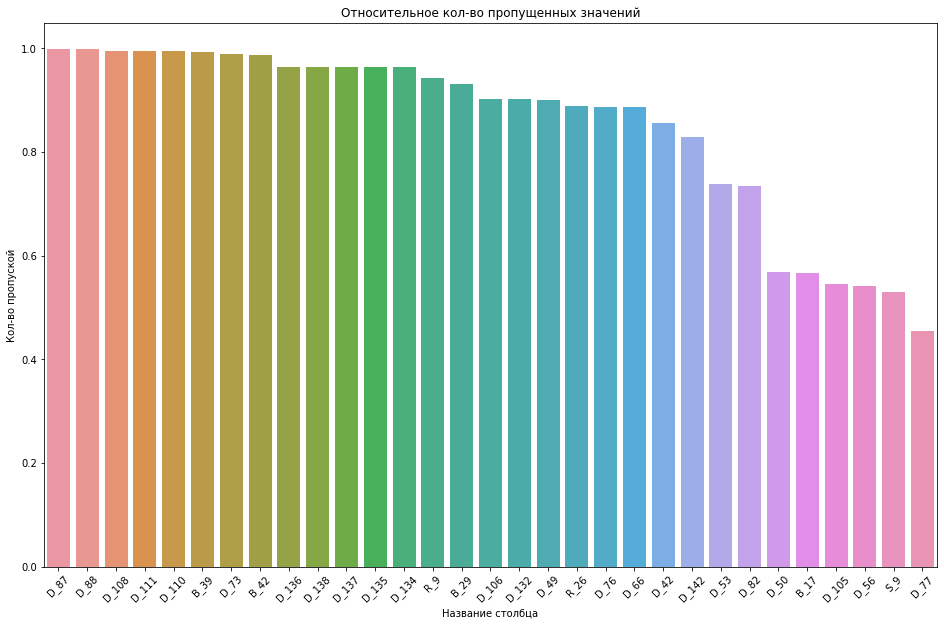

In [ ]:
plt.figure(figsize=(16,10))

sns.barplot(
    x = missing_values[missing_values > 0.4].index, 
    y = missing_values[missing_values > 0.4]
)

plt.xticks(rotation=45)
plt.title('Относительное кол-во пропущенных значений')
plt.ylabel("Кол-во пропуской")
plt.xlabel("Название столбца")
None

# Распределение целевой переменной

In [ ]:
target_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pet project/train_labels.csv')
target_dist = target_df['target'].value_counts(normalize=True).mul(100)

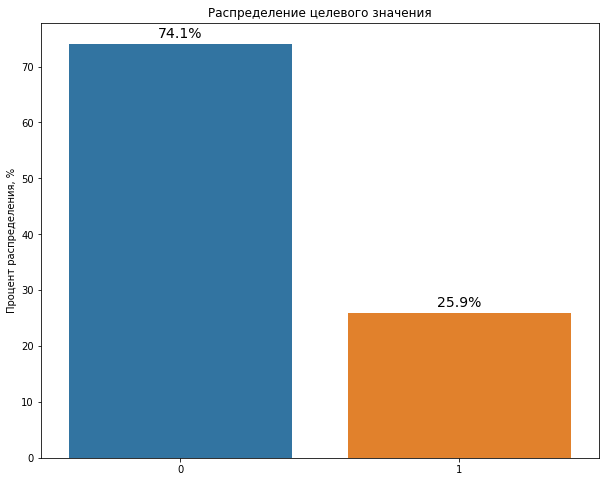

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.barplot(
    x = target_dist.index, 
    y = target_dist
)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
plt.title("Распределение целевого значения")
plt.ylabel("Процент распределения, %")
plt.xlabel("Целевое значение");

***В датесете присутствует дисбаланс классов***

# Распределение клиентов по кол-ву записей

In [ ]:
target_count = train_df.groupby(['customer_ID', 'target'])['S_2'].count()
target_count = pd.DataFrame(target_count).reset_index()\
    .rename(columns={"S_2": "Counts"})
target_count.head()

,customer_ID,target,Counts
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,13


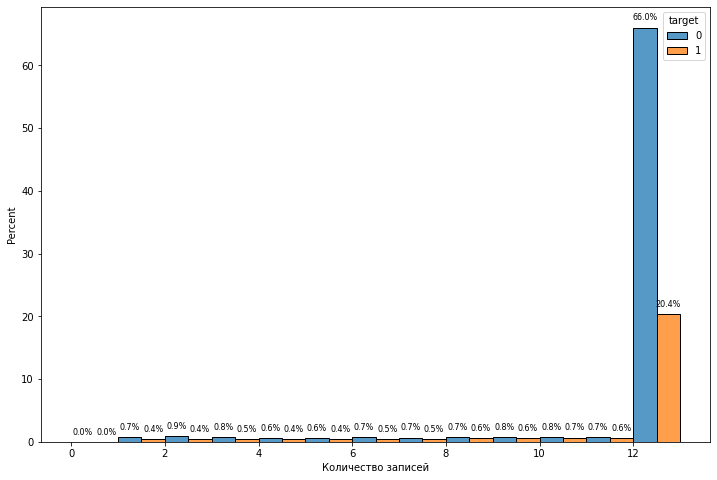

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

sns.histplot(x='Counts', data=target_count, hue='target', 
             stat='percent', multiple="dodge", bins=np.arange(0,14))

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=8)
plt.xlabel("Количество записей")
None

По распределению можно понять, что большая часть клиентов имеет 13 записей в датасете

Проверим как влияет количество записей в базе на то заплатит клиент или нет

In [ ]:
def barplot_group(df: pd.DataFrame, col_main: str, col_group: str, title: str) -> None:
    """Построение гистограммы распределения"""

    plt.figure(figsize=(17, 7))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage", hue=col_group, data=data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=10)

    plt.title(title, fontsize=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

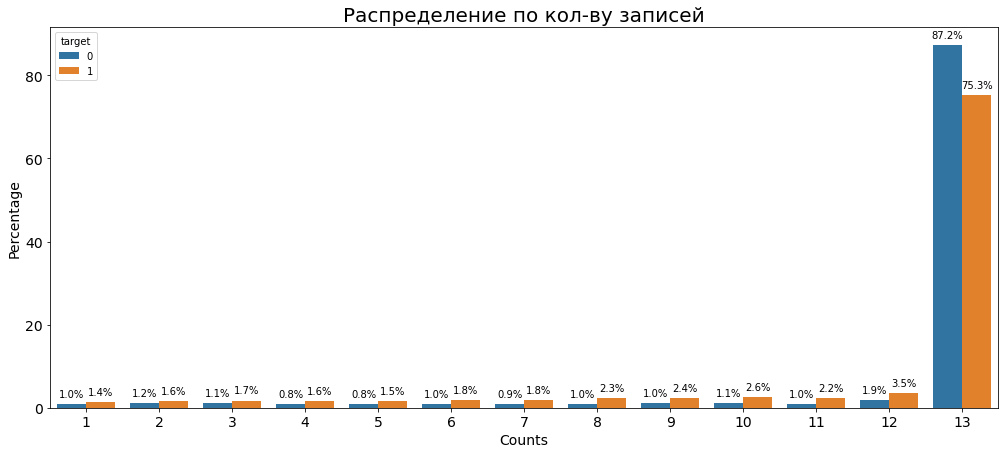

In [ ]:
barplot_group(target_count, "Counts", "target", 'Распределение по кол-ву записей')

По диаграмме видно, что с увеличением количества записей о людях возрастает процент неплательщиков (до 13 записи), хотя процент клиентов, которые платят остается стабильным

# Клиенты с меньшим кол-вом записей

Предположительно клиенты, которые имеют менее 13 записей могут являться: теми кто уже выплатил долг, новыми клиентами или теми кто перстал платить 

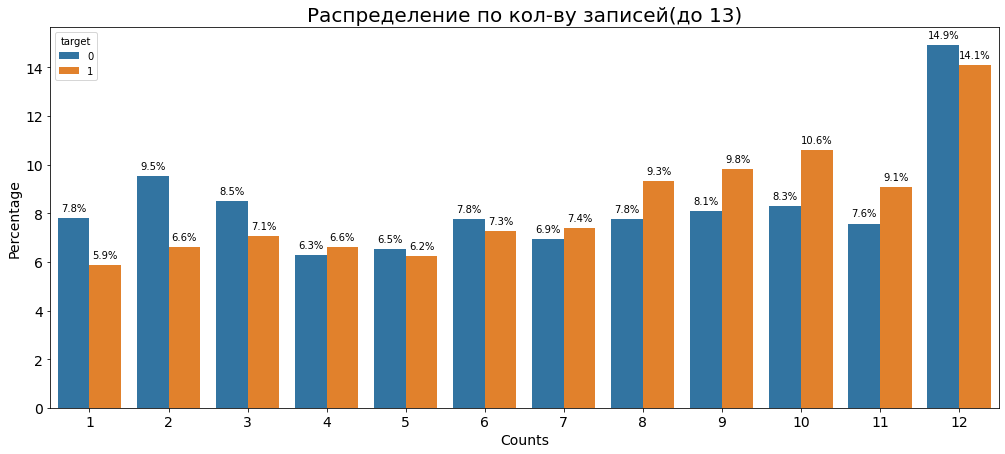

In [ ]:
less_13 = target_count[target_count['Counts'] < 13]
boxplot_group(less_13, "Counts", "target", 'Распределение по кол-ву записей(до 13)')

In [ ]:
train_df_date = train_df.groupby('customer_ID').agg(
    records=("target", "count"),
    date_max=("S_2", "max"),
    date_min=("S_2", "min")
)

# Разница в днях между первой и следней записью
train_df_date['delta_date'] = train_df_date['date_max'] - train_df_date['date_min']
train_df_date['delta_date'] = train_df_date['delta_date'].astype('timedelta64[D]').astype(int)

# Добавление целевой переменной
train_df_date.reset_index(inplace=True)
train_df_date = train_df_date.merge(target_df, on='customer_ID', how='left')

train_df_date.head()

,customer_ID,records,date_max,date_min,delta_date,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,2018-03-13,2017-03-09,369,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,2018-03-25,2017-03-01,389,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,2018-03-12,2017-03-11,366,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,2018-03-29,2017-03-31,363,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,2018-03-30,2017-03-30,365,0


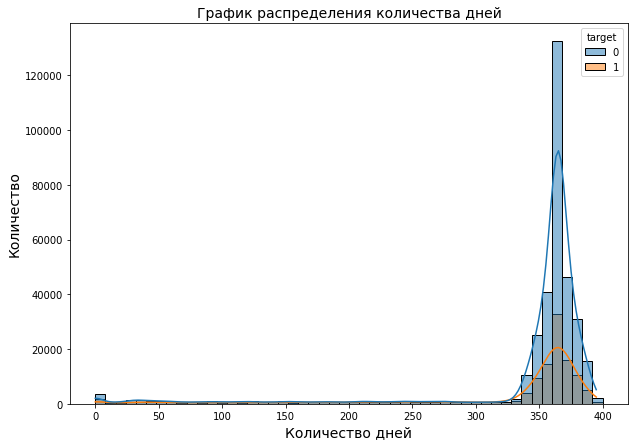

In [ ]:
# График распределения количества дней, которые клиент находится в базе

plt.figure(figsize=(10, 7))

sns.histplot(data=train_df_date, x="delta_date", hue="target", binwidth=8, kde=True)

plt.ylabel('Количество', fontsize=14)
plt.xlabel("Количество дней", fontsize=14)
plt.title('График распределения количества дней', fontsize=14)

plt.show()

In [ ]:
# Необходимо определить последнюю дату записи в базе для клиентов у которых есть все 13 записей
min_date_13 = train_df_date[train_df_date.records == 13]['date_max'].min()
max_date_13 = train_df_date[train_df_date.records == 13]['date_min'].max()
print(min_date_13, max_date_13, sep='\n')

2018-03-01 00:00:00
2017-03-31 00:00:00


## 1. Есть ли записи о неактивных клиентах

Проверим есть ли в базе люди, которых выплатили долг до 2018-03-01

In [ ]:
train_df_date[train_df_date['date_max'] < min_date_13]

,customer_ID,records,date_max,date_min,delta_date,target


**Таких людей нет, зачит все клиенты являются действующими**

## 2. Записи о новых клиентах

Проверим появлялись ли новые клиенты после 2017-03-31

In [ ]:
n_clients = train_df_date[(train_df_date['date_min'] > max_date_13)].shape[0]
print('Количество новых клиентов:', n_clients)

Количество новых клиентов: 63283


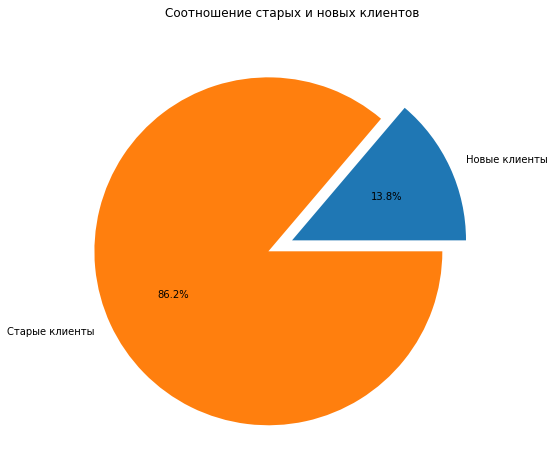

In [ ]:
vals = [n_clients, train_df_date.shape[0] - n_clients]
labels = ['Новые клиенты', 'Старые клиенты']

plt.figure(figsize=(8, 8))
plt.pie(vals, labels=labels, explode=(0, 0.15), autopct='%1.1f%%')
plt.title('Соотношение старых и новых клиентов')
plt.show()

(Под старыми клиентами подразумеваются люди информация о которых была добавлена в базу до 2017-03-31, соответственно новые клиенты - это те, информация про которых была добавлена после 2017-03-31)

**База содержит данные о клиентах с 2017-03-01 по 2018-03-31, общим количеством 458913 клиента из них 63283(13.8%) - это новые клиенты.**

Нужно проверить разницу в платежах между новыми клиентами и теми которые давно находятся в базе

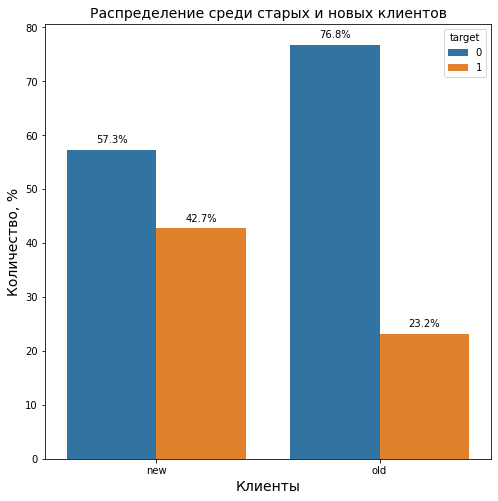

In [ ]:
new_clients = train_df_date[(train_df_date['date_min'] > max_date_13)]['target']\
                    .value_counts(dropna=False, normalize=True).sort_index()
old_clients = train_df_date[(train_df_date['date_min'] <= max_date_13)]['target']\
                    .value_counts(dropna=False, normalize=True).sort_index()

n_o_clients = pd.DataFrame({
    'clients': ['new'] * 2 + ['old'] * 2,
    'val_clients': pd.concat([new_clients, old_clients]) * 100, 
    'target': [0, 1] * 2
})

plt.figure(figsize=(8, 8))

ax = sns.barplot(x="clients", y="val_clients", hue="target", data=n_o_clients)
for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=10)
    
plt.ylabel('Количество, %', fontsize=14)
plt.xlabel("Клиенты", fontsize=14)
    
plt.title('Распределение среди старых и новых клиентов', fontsize=14)
plt.show()

**Исходя из гистрограммы можно сделать вывод, что клиенты которые находились в базе до 2017-03-31 лучше возвращают долг**

# Зависимость выплат от времени года

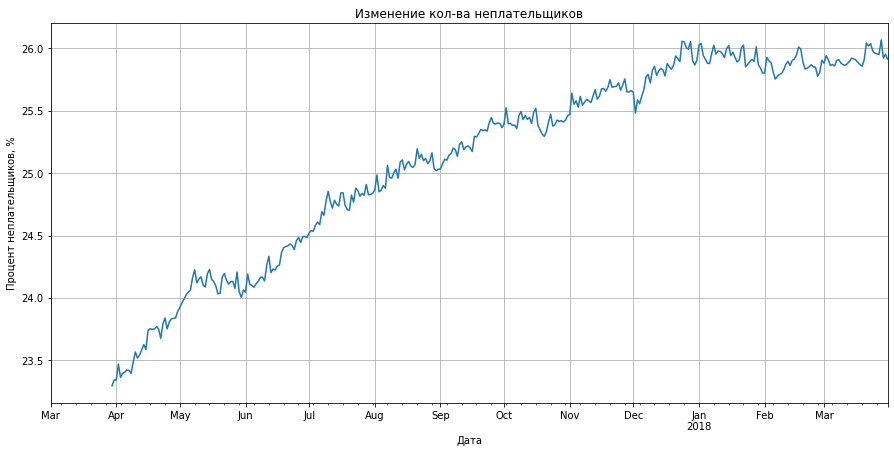

In [ ]:
plt.figure(figsize=(15, 7))

date_ser = train_df.groupby(['S_2'])['target'].mean()
date_ser.rolling('30D', min_periods=30).mean().mul(100).plot(
    title="Изменение кол-ва неплательщиков",
    xlabel='Дата',
    ylabel='Процент неплательщиков, %',
    grid=True
)
None

Количество людей, которые не возвращают деньги, увеличивается начиная с апреля 2017 года и продолжает возростать до января 2018 года. С января и до конца марта 2018 года процент невыплат практически не изменяется.

# Категориальных данных

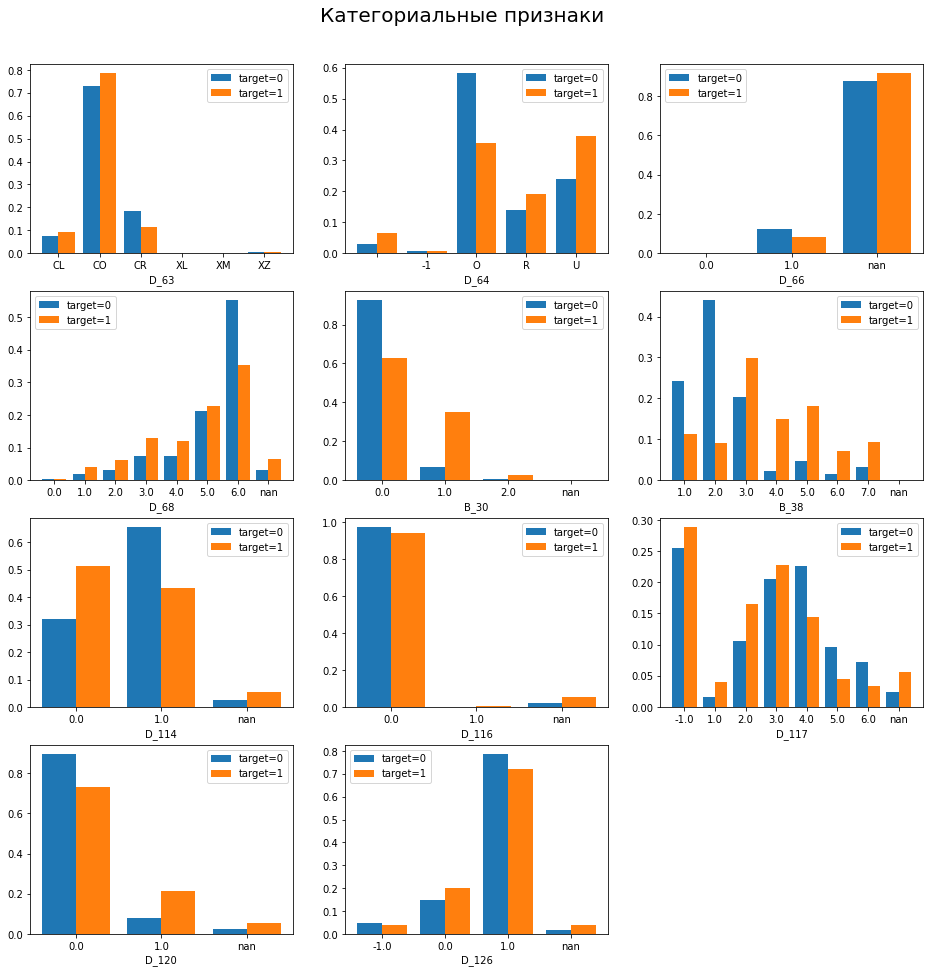

In [ ]:
cat_col = train_df.select_dtypes(include=['category']).columns

plt.figure(figsize=(16, 16))

for i, cols in enumerate(cat_col):
    plt.subplot(4, 3, i+1)
    target_0 = train_df[train_df.target == 0][cols].value_counts(dropna=False, normalize=True).sort_index()
    target_1 = train_df[train_df.target == 1][cols].value_counts(dropna=False, normalize=True).sort_index()
    
    indx = target_0.index.to_list()
    indx_size = len(indx)

    x1 = np.arange(0, indx_size) - 0.2
    x2 = np.arange(0, indx_size) + 0.2

    plt.bar(x1, target_0.values, width = 0.4, label='target=0')
    plt.bar(x2, target_1.values, width = 0.4, label='target=1')
    plt.legend()
    plt.xticks(np.arange(0, indx_size), indx)
    plt.xlabel(cols)

plt.suptitle('Категориальные признаки', fontsize=20, y=0.93)
plt.show()

Большая часть категориальных данных имеет схожее рапределение между клиентами, которы платят и теми кто не платит. Значительная разница наблюдается для признака B_38, значение 1.0 и 2.0 имеют больше клиенты которые платят. Так же для признака B_30 имеется перевес в категория 0.0 для платящих клиентов и перевес для категории 1.0 неплатящих клиентов



# Числовые данных

In [ ]:
def sub_histplot(title: list, columns: int = 5) -> None:
    """
    Построение распределения признаков для числовых данных.

    Параметры:
        title (list): список признаков для построения распределения
        columns (int): кол-во выводимых колонок с графиками
    """

    plot_size = len(title)
    fig, axes = plt.subplots(plot_size // columns + 1,
                             columns,
                             figsize=(16, 4 * (plot_size // columns + 1)))

    fig.suptitle(f'Распределение значений для признаков {title[0][0]}')
    for num, i in enumerate(title):
        if plot_size > columns:
            sns.kdeplot(ax=axes[num // columns, num % columns],
                        data=train_df,
                        x=i,
                        hue='target')
        else:
            sns.kdeplot(ax=axes[num % columns],
                        data=train_df,
                        x=i,
                        hue='target')

    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

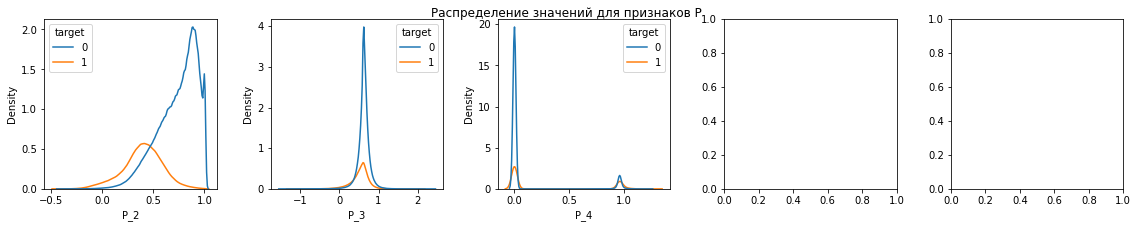

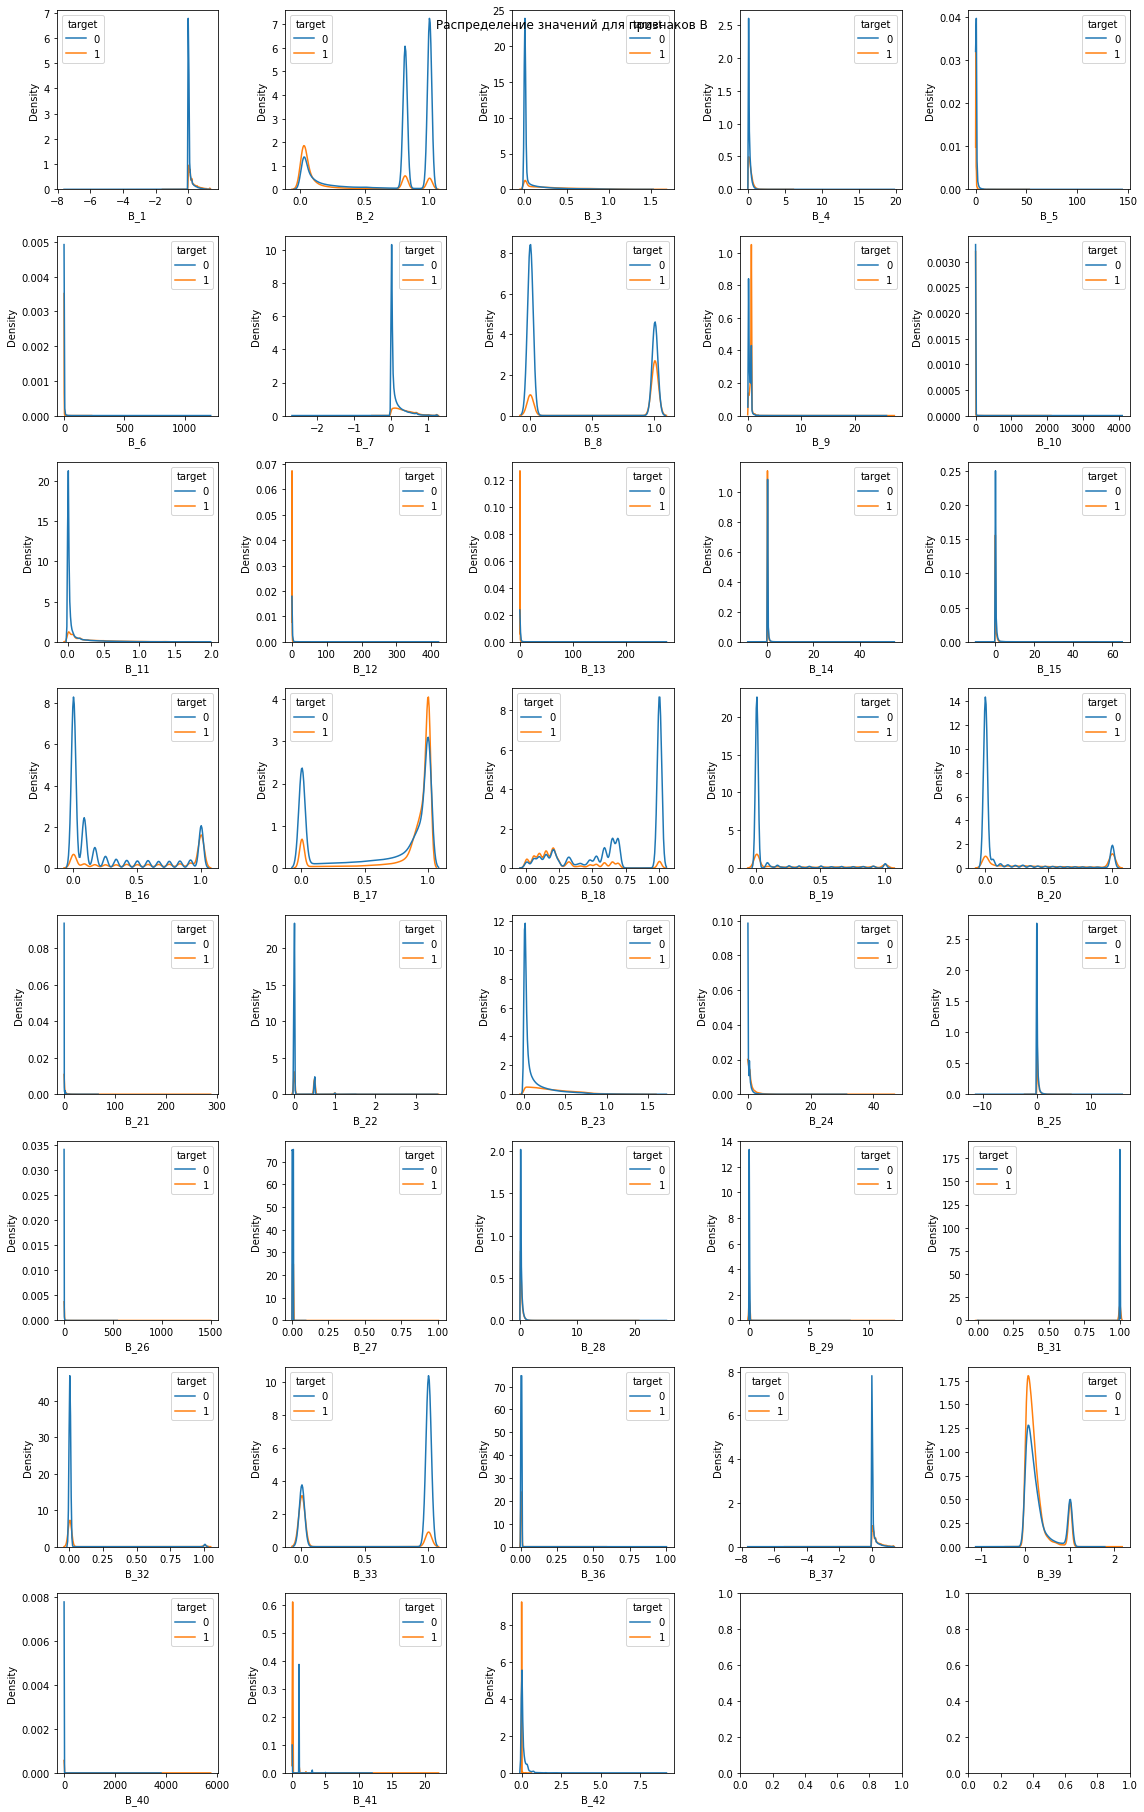

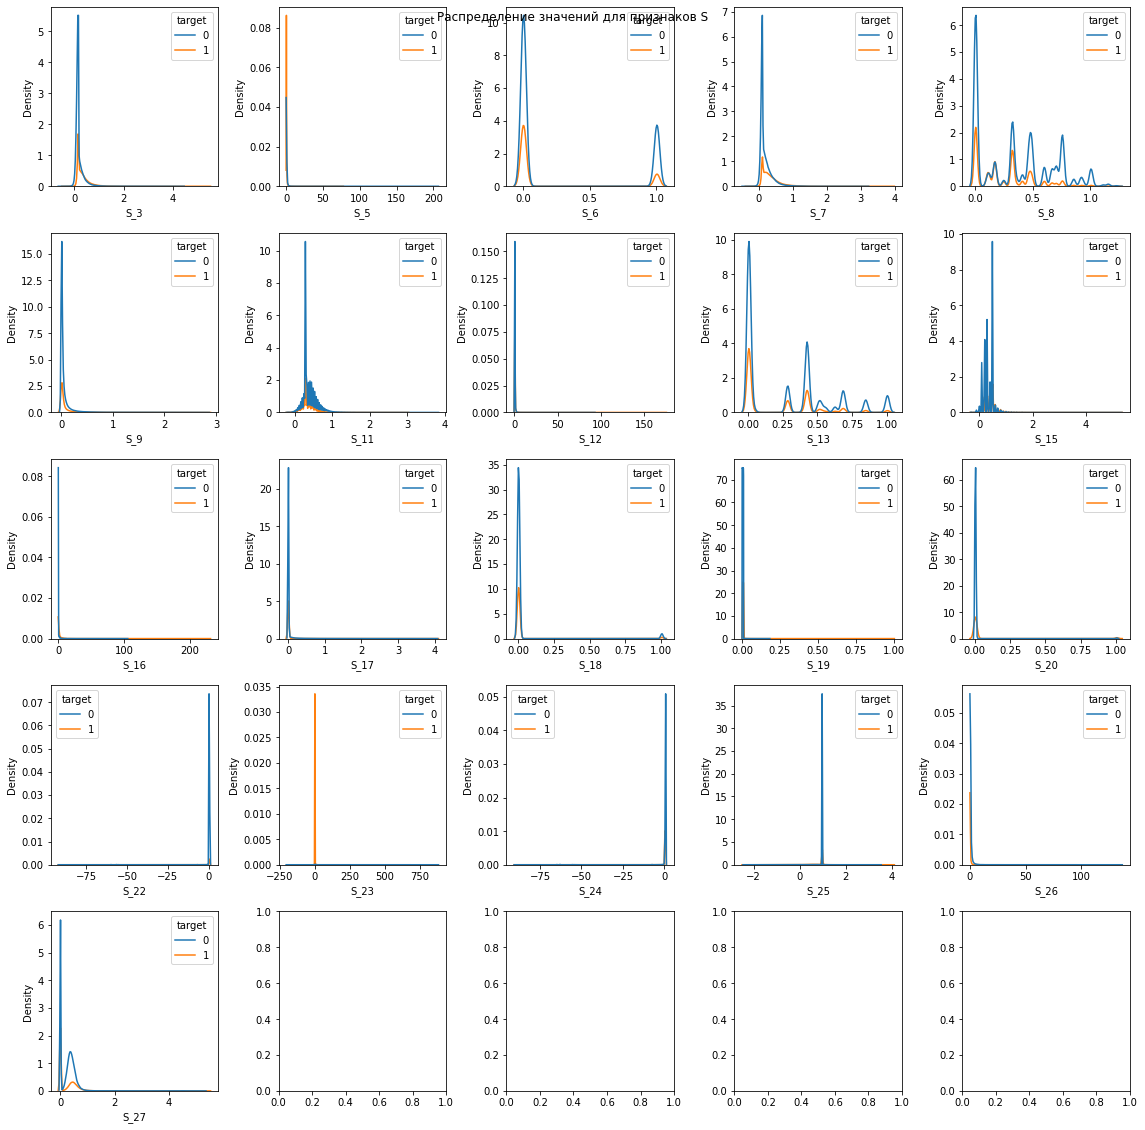

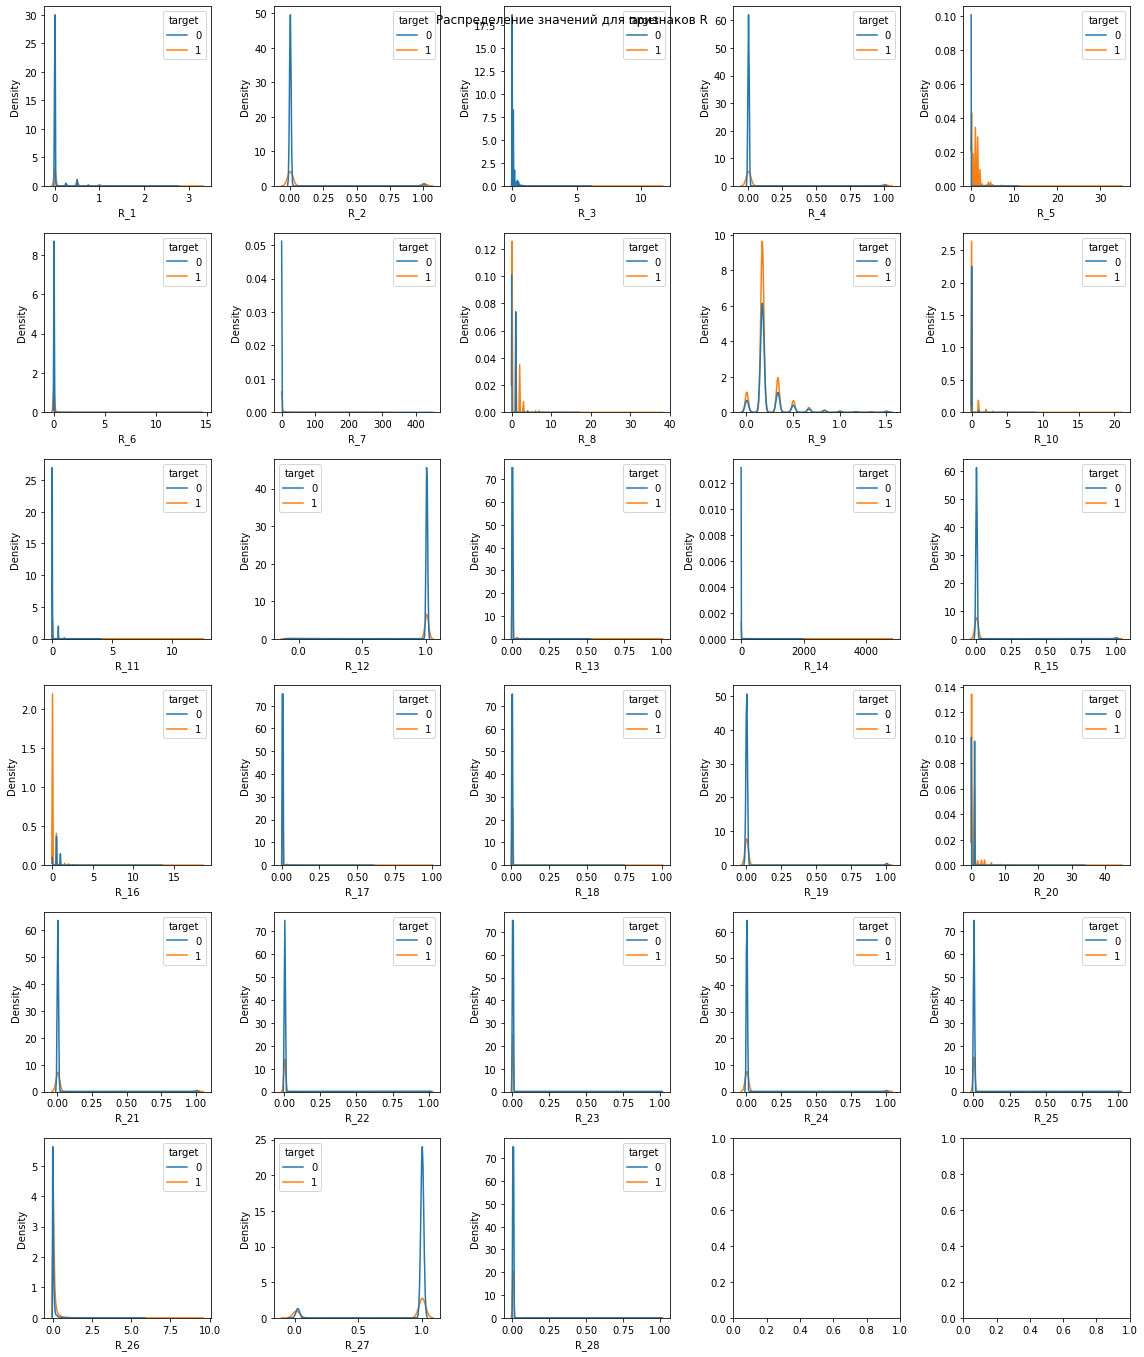

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


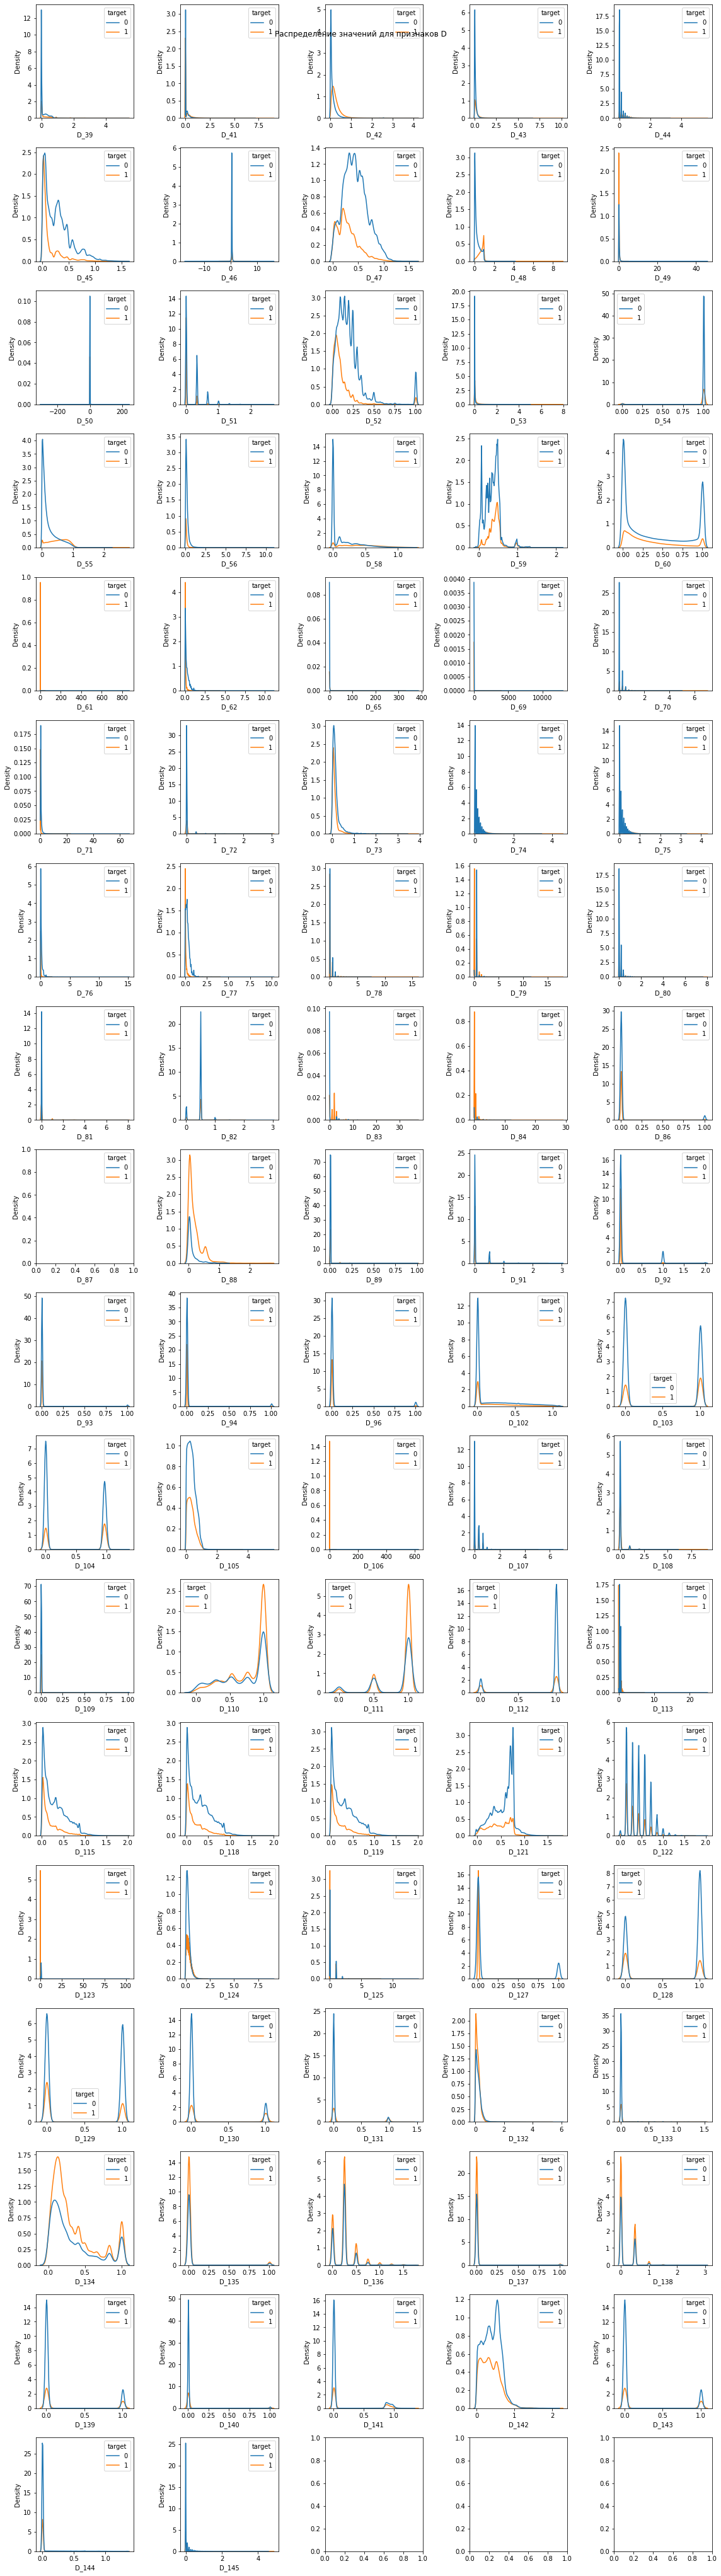

In [ ]:
dig_col = train_df.select_dtypes(include=['float16']).columns

for variables in ['P_', 'B_', 'S_', 'R_', 'D_']:
    sub_histplot([i for i in dig_col if variables in i])

Распределение по признаками для платящих и неплатящих клиентов схожи. Имеется разница в распределении по признаку: P_2, B_7, B_18, B_23, B_41, S_23, R_5, R_16, D_45, D_47, D_83

# Корреляция с целевой переменной

In [ ]:
def heatmap_corr(title: list) -> None:
    """
    Построение тепловой карты корреляции для группы признаков.

    Параметры:
        title (list): список признаков для вычисления корреляции
    """
    
    plt.figure(figsize=(15, 7))
    df_corr = train_df[title + ['target']].corr()
    matrix = np.triu(df_corr)
    sns.heatmap(df_corr, mask=matrix)
    plt.title(f'Корреляция с признаками {title[0][0]}', fontsize=20)
    plt.show()

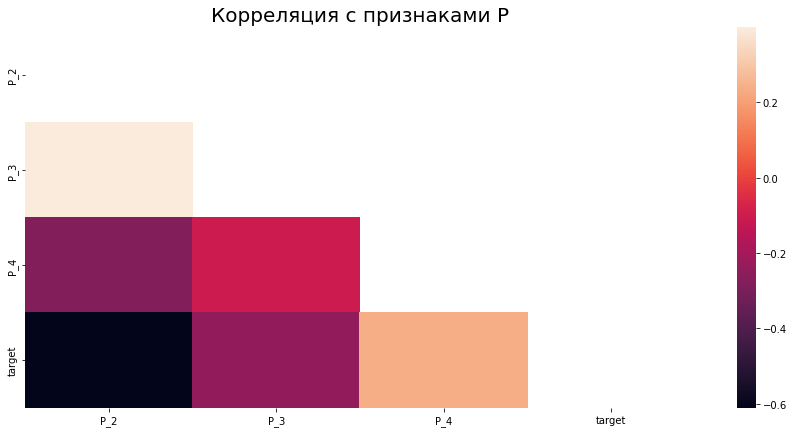

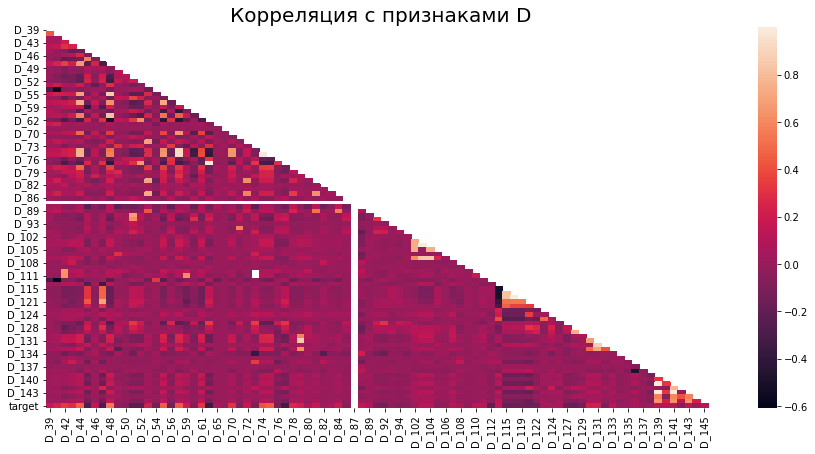

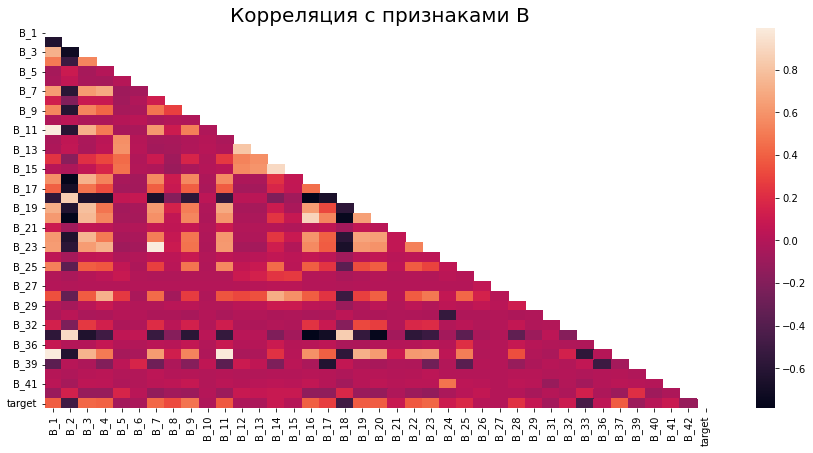

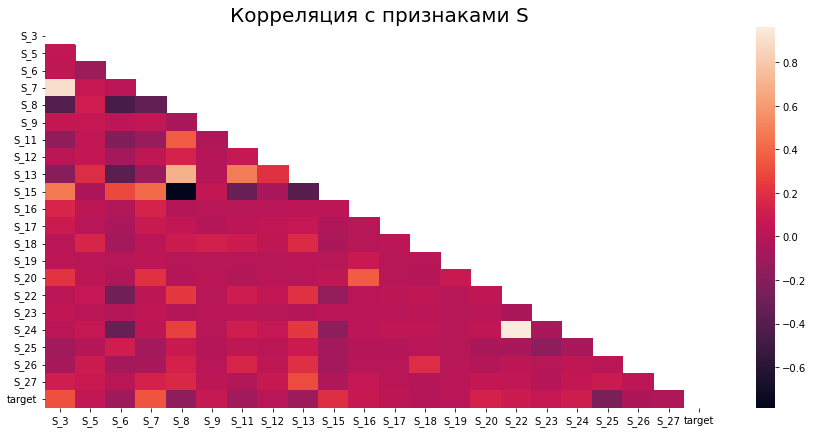

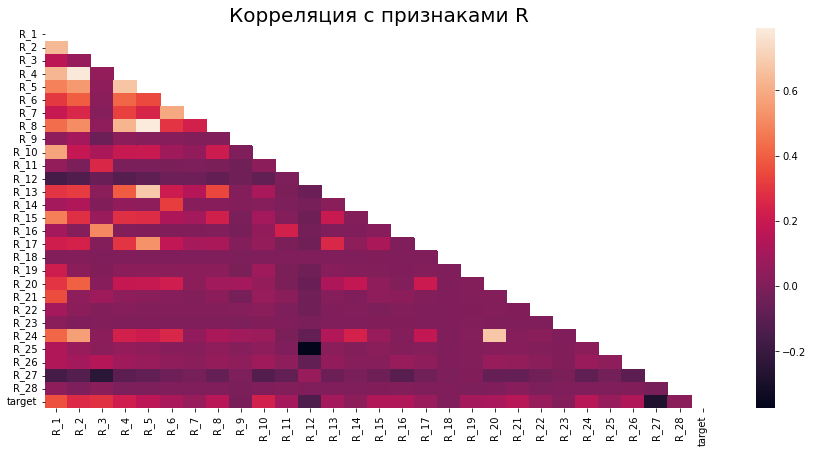

In [ ]:
for variables in ['P_', 'D_', 'B_', 'S_', 'R_']:
    heatmap_corr([i for i in train_df.columns if variables in i and i != 'S_2'])

Наибольшей положительной корреляцией с целевым значением явлеяется признак **D_48**, с отрицательной корреляцией **P_2**

In [ ]:
corr=train_df.corr()
corr=corr['target'].sort_values(ascending=False)[1:-1]

**Наибольшая положительная корреляция с целевой переменной**

In [ ]:
corr.head(10)

D_48    0.549362
B_9     0.475858
D_44    0.470412
D_75    0.457557
D_55    0.456671
D_58    0.448642
B_7     0.430917
B_3     0.429695
B_23    0.423175
D_74    0.421407
Name: target, dtype: float64

**Наибольшая отрицательная корреляция с целевой переменной**

In [ ]:
corr.tail(10)

D_51   -0.249153
D_45   -0.270544
R_27   -0.277071
D_47   -0.280047
D_77   -0.335407
D_62   -0.352230
B_33   -0.452972
B_2    -0.483062
B_18   -0.487393
P_2    -0.610765
Name: target, dtype: float64

# Feature engineering

## Получение новых признаков

In [ ]:
train_df.sort_values(by=['customer_ID', 'S_2'], inplace=True)
train_df.drop(columns='target', inplace=True)

In [ ]:
# Удаление колонок с большим количеством пропусков

many_passes_col = ['D_66']
for i, j in zip(train_df.columns.to_list(), train_df.isnull().mean()):
    if j >= 0.5:
        many_passes_col.append(i)
    
train_df.drop(columns=many_passes_col, inplace=True)
print('Количество удаленных столбцов:', len(many_passes_col))

Количество удаленных столбцов: 31


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Категориальные и цифровые колонки датасета
cat_col = train_df.select_dtypes(include=['category']).columns.to_list()
dig_col = [i for i in train_df.columns if i not in cat_col + ['S_2', 'customer_ID']]

# Кодирование категориальных данных
le_cat_col = {i: LabelEncoder().fit(train_df[i]) for i in cat_col}

In [ ]:
def preproc_cat_num(
    data: pd.DataFrame, categorical_col: list, numeric_col: list
    ) -> pd.DataFrame:
    """
    Создание новых признаков для категориальных и числовых колонок. Для 
    категориальных признаков: 'count', 'last', 'nunique'. Для числовых 
    признаков: 'mean', 'std', 'min', 'max', 'last', 'quantile25', 'quantile50', 
    'quantile75', '_diff'.

    Параметры:
        data (pd.DataFrame): датафрейм с обрабатываемыми данными
        categorical_col (list): список категориальных столбцов
        numeric_col (list): список числовых столбцов
    Возвращаемое значение:
            result (pd.DataFrame): датафрейм с новыми признаками
    """

    # Применение трансформирования LabelEncoder к категориальным данным
    data[categorical_col] = data[categorical_col].apply(
        lambda col: le_cat_col[col.name].transform(col))

    # Признаки для числовых свойств
    digt_group = data.groupby("customer_ID")[numeric_col]
    data_num_1 = digt_group.agg(['mean', 'std', 'min', 'max', 'last'])\
                                                        .astype('float16')
    data_num_2 = digt_group.quantile([.25, .5, 0.75]).unstack()\
                                                        .astype('float16')
    # Вычисление относительной разницы между последней и предпоследней 
    # датой для каждого признака
    data_num_3 = digt_group.diff(1) / digt_group.shift(periods=1)
    data_num_3 = data_num_3.add_suffix('_diff').astype('float16')
    data_num_3 = pd.concat([data['customer_ID'], data_num_3], axis=1)
    data_num_3 = data_num_3.groupby(['customer_ID']).last().astype('float16')
    
    # Признаки для категориальных свойств
    data_cat = data.groupby("customer_ID")[categorical_col].agg(
        ['count', 'last', 'nunique']).astype('category')

    # Объединение новых числовых и категориальных признаков
    result = pd.concat([data_num_1, data_num_2, data_num_3, data_cat], axis=1)
    result.columns = [
        f'{i[0]}_{i[1]}' if len(i) == 2 else i for i in result.columns
        ]
    
    del data_num_1, data_num_2, data_num_3, data_cat
    gc.collect()
    return result


df = preproc_cat_num(train_df, cat_col, dig_col)
df.shape

(3316, 1362)

## Отбор признаков

In [ ]:
def feature_selection_corr(data: pd.DataFrame, corr_value: float = 0.9) -> list:
    """
    Отбор признаков со значением корреляции ниже установленного в параметре 
    corr_value.

    Параметры:
        data (pd.DataFrame): датафрейм с обрабатываемыми данными
        corr_value (float): значение корреляции выше которого признаки удаляются
    Возвращаемое значение:
            result (list): список столбцов, которые остаются
    """
    
    deleted_colm = []
    left_colm = []

    corr_df = data.corr()
    for col in corr_df.columns:
        corr_list = corr_df[
            (corr_df[col].abs() > corr_value) & (corr_df[col].abs() != 1.0)
        ][col].index.to_list()
        if col not in deleted_colm:
            left_colm.append(col)
        deleted_colm.extend(corr_list)

    return left_colm + data.select_dtypes('category').columns.to_list()


new_column = feature_selection_corr(df)
df = df[new_column]

## Обработка пропущенных значений

In [ ]:
def replacing_missing_values(date: pd.DataFrame,
                             change_to: float = -1000.) -> pd.DataFrame:
    """
    Замена пропущенных данных в числовых признаках.
    
    Параметры:
        data (pd.DataFrame): датафрейм с пропущенными данными
        change_to (float): значение на которое заменяется пропущенные значения
    Возвращаемое значение:
        data (pd.DataFrame): датафрейм без пропущенными данными
    """
    
    float_data = date.select_dtypes('float16').columns.to_list()
    not_float = [i for i in date.columns.to_list() if i not in float_data]
    return pd.concat([
        date[not_float], date[float_data].fillna(change_to).astype('float16')
    ],
                     axis=1)


df = replacing_missing_values(df)

In [ ]:
# Соединение обработанного датафрейма с таргет метками
df = df.merge(target_df, on='customer_ID')

# Сохранение подготовленных тренировочных данных
df.to_feather('train_data_prep.ftr')

del df, train_df
gc.collect()

0

## Обработка тестовых данных

In [ ]:
test_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/test_data.ftr')
test_df.sort_values(by=['customer_ID', 'S_2'], inplace=True)

In [ ]:
# Удаление столбцов с большим кол-вом пропусков
test_df.drop(columns=many_passes_col, inplace=True)

test_df = preproc_cat_num(test_df, cat_col, dig_col)

test_df = test_df[new_column]
test_df = replacing_missing_values(test_df)
test_df.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Сохранение подготовленных тестовых данных
test_df.to_feather('test_data_prep.ftr')